In [24]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

    x  n_left   GI_left  n_right    acc  GI_right  GI_weighted   GI_gain
0  36     360  0.099985      640  0.727  0.478730     0.342382  0.175668
0  39     386  0.130111      614  0.737  0.473257     0.340803  0.177247
0  38     375  0.115143      625  0.734  0.475269     0.340222  0.177828


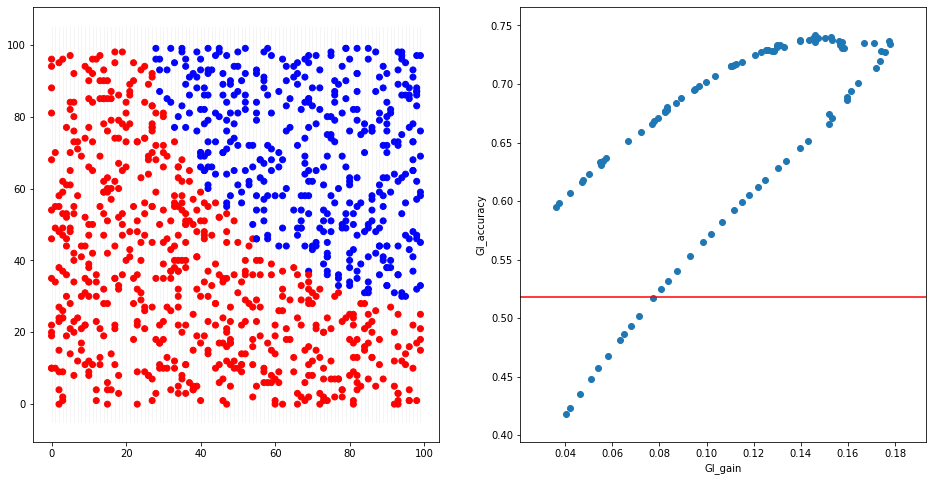

In [445]:
n_points = 1000
n_cuts = 100

p_x = sorted([random.randint(0, 99) for p in range(0, n_points)])
p_y = [random.randint(0, 99) for p in range(0, n_points)]

data = pd.DataFrame({"p_x": p_x,
                     "p_y": p_y})

classes = np.sqrt((data.p_x*data.p_y))
data["truth"] = ["blue" if x > 50 else "red" for x in classes]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)

ax1.scatter(x=data.p_x, 
            y=data.p_y, 
            c=data.truth,
            alpha=1)

# randomly draw lines for splits
# x_coords = sorted([random.randint(0, 99) for p in range(0, n_cuts)])
x_coords = range(0, n_cuts, 1)

for x_coord in x_coords:
    
    ax1.plot([x_coord, x_coord], [-5, 105], 
             color="grey", 
             linestyle='-', 
             linewidth=0.75,
             alpha=0.1)
    
    correct = ["blue" if x > x_coord else "red" for x in p_x]
    data = pd.concat([data, pd.DataFrame({"x@"+str(x_coord):correct})], axis=1)

cuts = pd.DataFrame()    
    
for c in data.columns:
    
    if "@" in c:
        
        x_cutoff = int(c[2:])
        
        ########################################################################
        # Count left side of split
        
        left = data[data.p_x <= x_cutoff]
        left_counts = {"red": 0, "blue": 0}
        
        tmp = left["truth"].value_counts().to_dict()
        
        for k in tmp:
            
            left_counts[k] = tmp[k]
        
        n_red = left_counts["red"]
        n_blue = left_counts["blue"]
        
        if (n_red > 0 and n_blue > 0):
            
            n_red_p = (n_red / (n_red + n_blue))
            n_blue_p = (n_blue / (n_red + n_blue))
            gi_left = (n_red_p * (1-n_red_p)) + (n_blue_p * (1-n_blue_p)) 
        
        else:
            
            gi_left = 0
            
        n_left = n_red + n_blue
            
        ########################################################################
        # Count right side of split
        
        right = data[data.p_x > x_cutoff]
        right_counts = {"red": 0, "blue": 0}
        
        tmp = right["truth"].value_counts().to_dict()
        
        for k in tmp:
            
            right_counts[k] = tmp[k]
        
        n_red = right_counts["red"]
        n_blue = right_counts["blue"]
        
        if (n_red > 0 and n_blue > 0):
            
            n_red_p = (n_red / (n_red + n_blue))
            n_blue_p = (n_blue / (n_red + n_blue))
            gi_right = (n_red_p * (1-n_red_p)) + (n_blue_p * (1-n_blue_p)) 
        
        else:
            
            gi_right = 0
            
        n_right = n_red + n_blue
            
        ########################################################################
        # Calculate true positives for accuracy
        
        counts = {"True": 0, "False": 0}
        
        tmp = (data.truth == data[c]).value_counts().to_dict()
        
        for k in tmp:
            
            counts[str(k)] = tmp[k]
        
        acc = counts["True"] / n_points
            
        ########################################################################
        # Add split to result df
        
        cuts = pd.concat([cuts, pd.DataFrame({"x": [x_cutoff], 
                                              "n_left": [n_left],
                                              "GI_left": [gi_left], 
                                              "n_right": [n_right],
                                              "acc": [acc],
                                              "GI_right": [gi_right]})])

################################################################################
# Calculate naive probability

p_naive = sum((data.truth.value_counts()/n_points)**2)

################################################################################
# Calculate weighted Gini Impurity

GI_w = []
GI_gainz = []
GI_accuracies = []

for _, cut in cuts.iterrows():
    
    GI_weighted = (cut.n_left/(cut.n_left + cut.n_right)) * cut.GI_left + \
                  (cut.n_right/(cut.n_left + cut.n_right)) * cut.GI_right
    
    GI_w.append(GI_weighted)
    GI_gainz.append(p_naive-GI_weighted)
    
cuts["GI_weighted"] = GI_w
cuts["GI_gain"] = GI_gainz

print(cuts.sort_values("GI_gain").tail(3))

ax2.scatter(cuts.GI_gain, cuts.acc)
ax2.set_xlabel("GI_gain")
ax2.set_ylabel("GI_accuracy")
ax2.axhline(y=p_naive, 
            color="r", 
            linestyle="-")
